<a href="https://colab.research.google.com/github/JunhyeongTPark/eeg_vae/blob/main/process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 142.9 MB/s eta 0:00:00


In [2]:
import os
import mne

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

import pickle
from google.colab import drive
import shutil

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


##Load Data

`output_epochs` is a dictionary with the subject ids ('subject-###') as the keys and mne epochs items as the values.

`participants.tsv` is loaded in to determine the specific classification of patients. The original dataset had only labeled PD vs Control but had criteria for determining PD vs PDMCI vs PDD.

In [4]:
with open('/content/drive/MyDrive/Colab_Notebooks/output_epochs.pkl', 'rb') as f:
    output_epochs = pickle.load(f)

annots = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/participants.tsv', sep='\t')

labels_vec = np.select(
            [
                annots['GROUP'] == 'Control', # Control (Control)
                (annots['MOCA'] >= 26) & (annots['GROUP'] == 'PD'), # Parkinson's Disease (PD)
                (annots['MOCA'] >= 22) & (annots['MOCA'] < 26), # mild-cognitive impairment (PDMCI)
                annots['MOCA'] < 22 # Dementia (PDD)
            ],
            [0, 1, 2, 3]
        )
label_map = {'Control': 0, 'PD': 1, 'PDMCI': 2, 'PDD': 3}

## Quick PSD Analysis

Although PSD analysis may be insufficient for discovering distinctive EEG biomarkers, it may reveal general trends between patients of different classes.

From a prelimnary glance, there appears to be an increase in theta power (4-8hz) and a decrease in gamma power (>30 hz) in PDD (dementia) patients vs control patients. This follows the majority finding for Parkinson's Disease patients.

**Note that this initial claim on this dataset is NOT statistically significant because no tests were run to support this. This was simply just a quick look to verify past findings.**

In [8]:
# PDD (Dementia) Patient (Sub-025)
raw_pdd = output_epochs['sub-025'].copy()

spectrum = raw_pdd.compute_psd(method='welch', fmin=1., fmax=100.)
psds = spectrum.get_data()
freqs = spectrum.freqs

psds.shape

Effective window size : 3.504 (s)


(182, 8, 347)

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


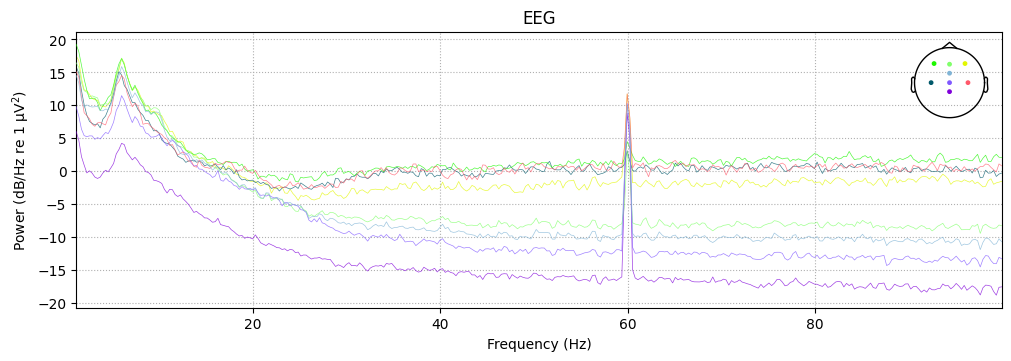

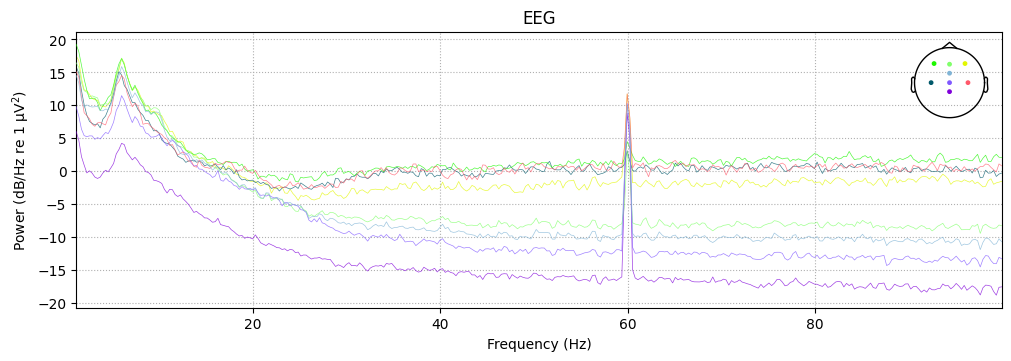

In [9]:
spectrum.plot(average=False, spatial_colors=True)

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


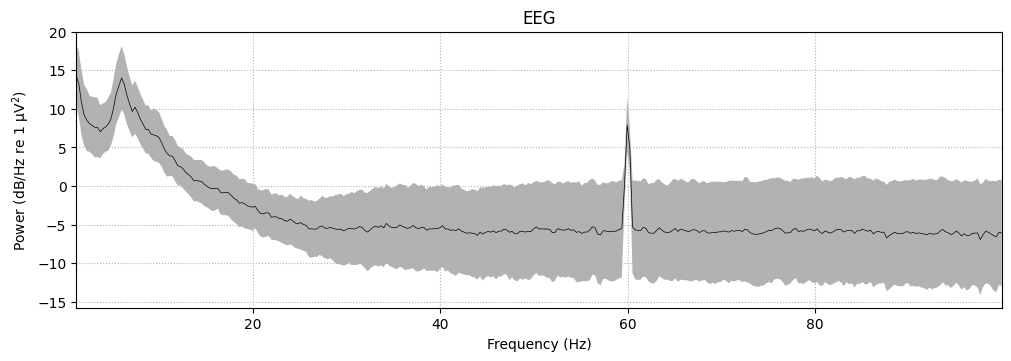

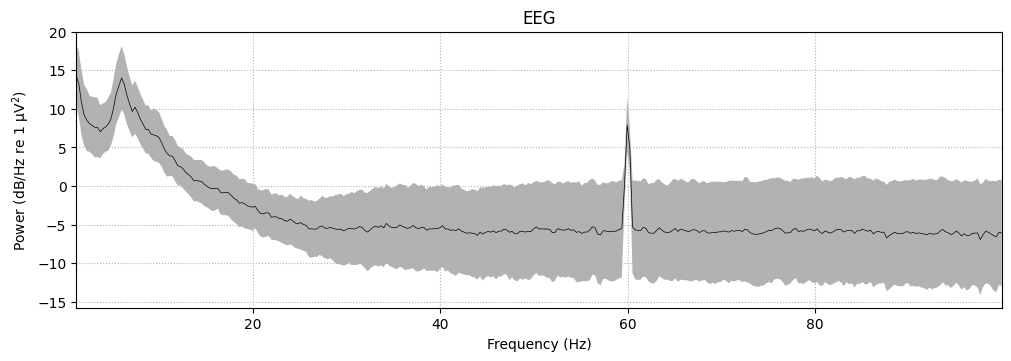

In [10]:
spectrum.plot(average=True, spatial_colors=True)

Averaging across epochs before plotting...


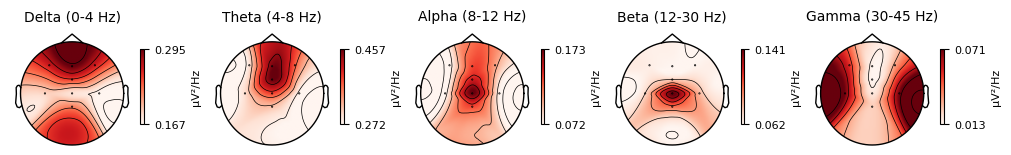

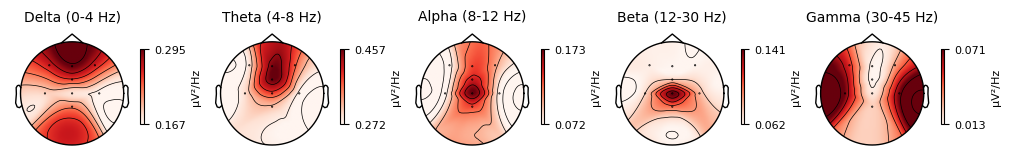

In [11]:
spectrum.plot_topomap(ch_type='eeg', normalize=True, show=True)

Effective window size : 3.504 (s)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


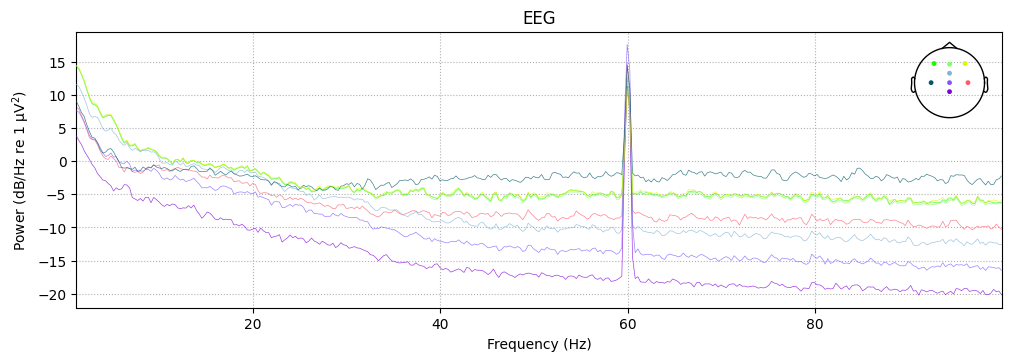

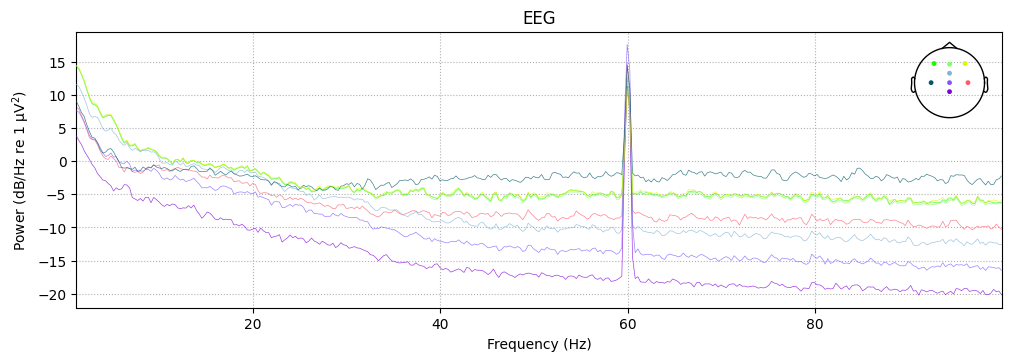

In [12]:
# Control Patient (Sub-146)
raw_control = output_epochs['sub-146'].copy()

spectrum = raw_control.compute_psd(method='welch', fmin=1., fmax=100.)
psds = spectrum.get_data()

spectrum.plot(average=False, spatial_colors=True)

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


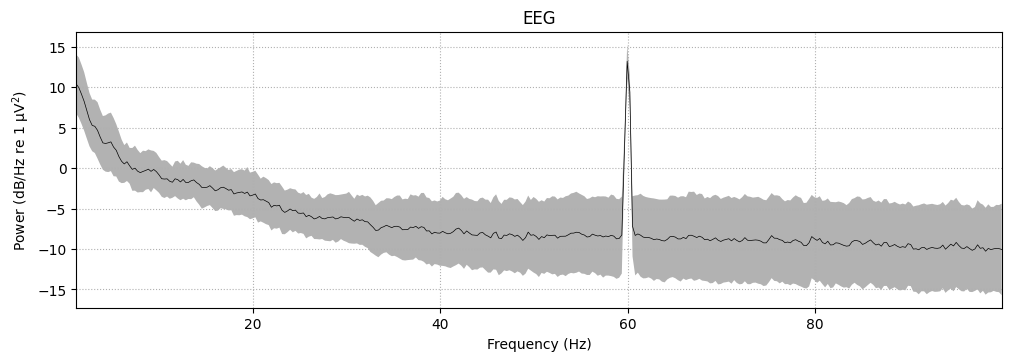

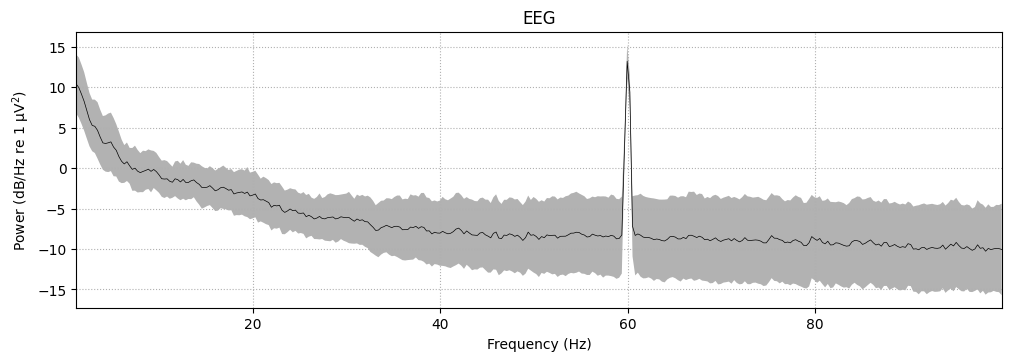

In [13]:
spectrum.plot(average=True, spatial_colors=True)

Averaging across epochs before plotting...


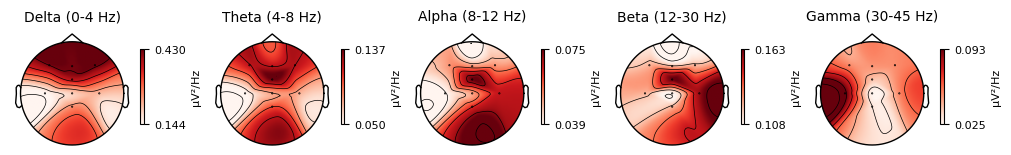

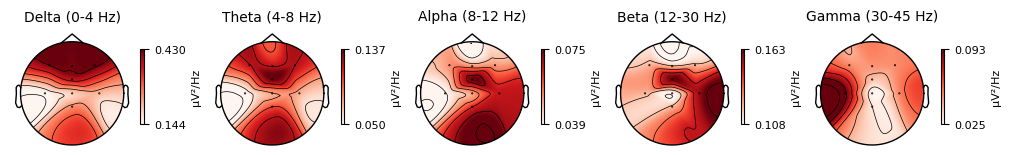

In [14]:
spectrum.plot_topomap(ch_type='eeg', normalize=True, show=True)

## Processing Functions

These functions were used to extract data from the epochs. Note that data for only the delta, theta, alpha, and beta bands were extracted due to the difficulty of reconstructing the gamma frequency band. Only the Cz channel data was collected as well (from `output_epochs_cz.pkl`). I opted to first focus on model development and analysis to derive what I can with limited resources before coming back to solve the issue of the gamma band reconstruction and additional channels. **Work in progress.**

In [53]:
# Above used output_epochs.pkl with 8 channels. For data collection (for now) we use output_epochs_cz.pkl
with open('/content/drive/MyDrive/Colab_Notebooks/output_epochs_cz.pkl', 'rb') as f:
    output_epochs = pickle.load(f)

In [54]:
BANDS = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13), "beta": (13, 30)}
SFREQ = 250
TRIM_TMIN, TRIM_TMAX = -0.2, 0.8
TMIN, TMAX = -1, 2.5
LOWER_TRIM = int(abs(TMIN - TRIM_TMIN) * SFREQ)
UPPER_TRIM = int(abs(TMAX - TRIM_TMAX) * SFREQ)
EPS = 1e-8

In [55]:
def process_data(output_epochs, freq_bands, process_method='time_freq'):
    all_subject_ids = list(output_epochs.keys())
    signals_list = []
    labels_list = []

    if process_method == 'time_freq':
        for subj_id, epochs in output_epochs.items():
            bands_list = []
            for band, (l_freq, h_freq) in freq_bands.items():
                filtered_data = epochs.copy().filter(l_freq, h_freq, verbose=False).get_data()
                trimmed_data = torch.tensor(filtered_data[:, :, LOWER_TRIM:-UPPER_TRIM], dtype=torch.float32)

                bands_list.append(trimmed_data)

            # Stack bands to create the [Epochs, Bands, Channels, Timepoints] tensor
            subject_signals = torch.stack(bands_list, dim=1)
            signals_list.append(subject_signals)

            # Create labels tensor with size [number of epochs, 2]
            subj_idx = int(subj_id[-3:]) - 1
            label_val = labels_vec[subj_idx]
            label_tensor = torch.full((len(epochs),2), fill_value=label_val, dtype=torch.long)
            # Add subject index to the second column for identification, will be removed later
            # Future thought: subject id column could maybe be used later for personalized classification (?)
            label_tensor[:,1] = subj_idx + 1
            labels_list.append(label_tensor)

        # Concatenate all subjects in the split into one large tensor
        return torch.cat(signals_list, dim=0), torch.cat(labels_list, dim=0)
    #elif process_method == 'hilbert':
    # TBD


In [56]:
# For verifying equal distribution of classes and subjects in each dataset
def verify_distributions(y_train, y_val, y_test):

    # helper function to get normalized value counts (percentages)
    def get_dist(y_data):
        y_data = y_data.numpy()
        return pd.Series(y_data).value_counts(normalize=True).sort_index()

    df = pd.DataFrame({
        'Train_Dist': get_dist(y_train),
        'Val_Dist':   get_dist(y_val),
        'Test_Dist':  get_dist(y_test)
    })

    df['Max_Diff'] = df.max(axis=1) - df.min(axis=1)

    print(f'\n--- Distribution Check ---')
    print(df.style.format('{:.2%}'))
    print(df.round(4))

    return df

In [57]:
def normalize_data(train_signals, train_labels,
                   val_signals, val_labels,
                   test_signals, test_labels):
    subjects = torch.unique(train_labels[:,1]).numpy()

    train_mus = []
    train_stds = []

    for sub_id in subjects:
        # Get mean and std of TRAINING data only
        train_sub_idx = torch.where(train_labels[:, 1] == sub_id)
        train_sub_signals = train_signals[train_sub_idx]

        mu = train_sub_signals.mean(dim=(0, 3), keepdim=True)
        std = train_sub_signals.std(dim=(0, 3), keepdim=True)

        val_sub_idx = torch.where(val_labels[:, 1] == sub_id)
        val_sub_signals = val_signals[val_sub_idx]

        test_sub_idx = torch.where(test_labels[:,1] == sub_id)
        test_sub_signals = test_signals[test_sub_idx]

        # Normalize all datasets on training mean and std
        train_signals[train_sub_idx] = (train_sub_signals - mu) / (std + EPS)
        val_signals[val_sub_idx] = (val_sub_signals - mu) / (std + EPS)
        test_signals[test_sub_idx] = (test_sub_signals - mu) / (std + EPS)

        train_mus.append(mu)
        train_stds.append(std)

    return train_signals, val_signals, test_signals, train_mus, train_stds

##Process TF Data

Data was normalized per subject, per band x channel pair, across all epochs and timepoints using the training data.

In [58]:
signals_data, labels = process_data(output_epochs, BANDS)

In [76]:
# Split data by labels
# This ensures an equal proportion of each class and subject are in each dataset
train_signals, temp_signals, train_labels, temp_labels = train_test_split(
    signals_data, labels, test_size=0.5, random_state=42, stratify=labels
)

val_signals, test_signals, val_labels, test_labels = train_test_split(
    temp_signals, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [77]:
# Verifying shapes
print(train_signals.shape)
print(train_labels.shape)
print(val_signals.shape)
print(val_labels.shape)
print(test_signals.shape)
print(test_labels.shape)

torch.Size([17349, 4, 1, 251])
torch.Size([17349, 2])
torch.Size([8674, 4, 1, 251])
torch.Size([8674, 2])
torch.Size([8675, 4, 1, 251])
torch.Size([8675, 2])


In [78]:
# Verify class balance
df_class = verify_distributions(
    train_labels[:, 0],
    val_labels[:, 0],
    test_labels[:, 0],
)


--- Distribution Check ---
   Train_Dist  Val_Dist  Test_Dist  Max_Diff
0      0.3269    0.3264     0.3273    0.0009
1      0.3240    0.3243     0.3235    0.0008
2      0.2204    0.2203     0.2204    0.0001
3      0.1287    0.1290     0.1289    0.0003


In [79]:
# Verify subject balance
df_subj = verify_distributions(
    train_labels[:, 1],
    val_labels[:, 1],
    test_labels[:, 1]
)


--- Distribution Check ---
     Train_Dist  Val_Dist  Test_Dist  Max_Diff
1        0.0068    0.0068     0.0068    0.0000
2        0.0068    0.0068     0.0069    0.0001
3        0.0069    0.0069     0.0069    0.0000
4        0.0069    0.0069     0.0069    0.0000
5        0.0069    0.0069     0.0069    0.0000
..          ...       ...        ...       ...
142      0.0069    0.0069     0.0069    0.0000
143      0.0069    0.0069     0.0069    0.0000
144      0.0069    0.0069     0.0069    0.0000
145      0.0069    0.0069     0.0069    0.0000
146      0.0069    0.0069     0.0069    0.0000

[146 rows x 4 columns]


In [80]:
# Get normalized data
train_signals_norm, val_signals_norm, test_signals_norm, train_mus, train_stds = normalize_data(train_signals, train_labels,
                                                                                                val_signals, val_labels,
                                                                                                test_signals, test_labels)
# Remove subject id labels for now, subject id labels not needed
train_labels = train_labels[:, 0]
val_labels = val_labels[:, 0]
test_labels = test_labels[:, 0]

In [81]:
# Reconfirm shape
print(train_signals_norm.shape)
print(val_signals_norm.shape)
print(test_signals_norm.shape)

torch.Size([17349, 4, 1, 251])
torch.Size([8674, 4, 1, 251])
torch.Size([8675, 4, 1, 251])


In [82]:
stats = {
    'mu': train_mus,
    'std': train_stds
}

In [83]:
torch.save({
    'train_signals': train_signals_norm,
    'train_labels': train_labels,
    'val_signals': val_signals_norm,
    'val_labels': val_labels,
    'test_signals': test_signals_norm,
    'test_labels': test_labels,
    'stats': stats
}, 'processed_data_cz.pt')

In [84]:
local_path = '/content/processed_data_cz.pt'
drive_path = '/content/drive/MyDrive/Colab_Notebooks/processed_data_cz.pt'

os.makedirs(os.path.dirname(drive_path), exist_ok=True)
shutil.copy(local_path, drive_path)

'/content/drive/MyDrive/Colab_Notebooks/processed_data_cz.pt'